[*********************100%%**********************]  1 of 1 completed


Sharpe Ratio: 3.778746411045611
Sortino Ratio: 5.500452901449727
Max Drawdown: -0.19892420239926767


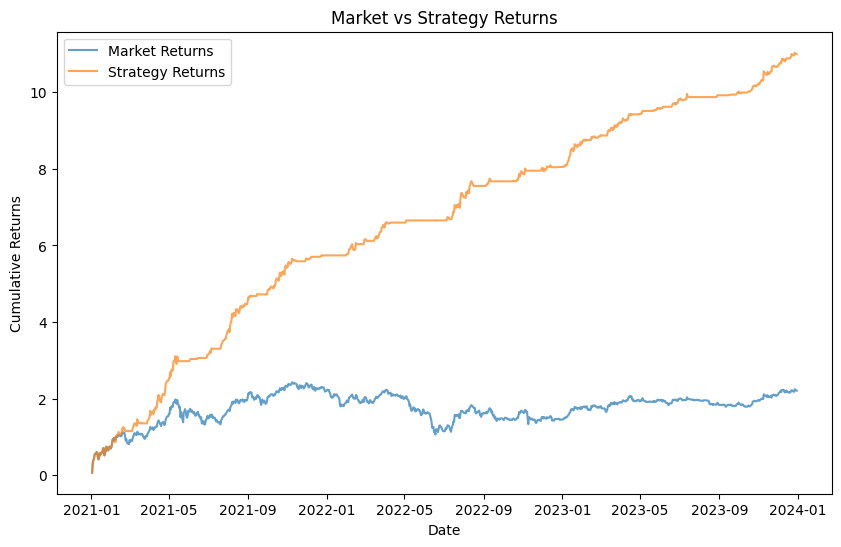

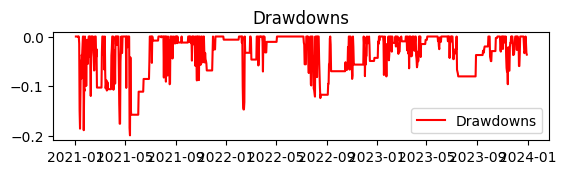

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

symbol = 'ETH-USD'
start_date = '2021-01-01'
end_date = '2023-12-31'
data = yf.download(symbol, start=start_date, end=end_date)

# Ichimoku Cloud
data['Tenkan'] = data['Close'].rolling(window=9).mean()
data['Kijun'] = data['Close'].rolling(window=26).mean()
data['Senkou_A'] = (data['Tenkan'] + data['Kijun']) / 2
data['Senkou_B'] = data['Close'].rolling(window=52).mean()



# ADX
window = 14
data['TR'] = data[['High', 'Low', 'Close']].apply(lambda x: max(x['High'] - x['Low'], abs(x['High'] - x['Close']), abs(x['Low'] - x['Close'])), axis=1)
data['DMplus'] = data['High'].diff().apply(lambda x: x if x > 0 else 0)
data['DMminus'] = data['Low'].diff().apply(lambda x: -x if x < 0 else 0)

data['EMA_TR'] = data['TR'].rolling(window=window).mean()
data['EMA_DMplus'] = data['DMplus'].rolling(window=window).mean()
data['EMA_DMminus'] = data['DMminus'].rolling(window=window).mean()

data['DIplus'] = (data['EMA_DMplus'] / data['EMA_TR']) * 100
data['DIminus'] = (data['EMA_DMminus'] / data['EMA_TR']) * 100

data['ADX'] = ((data['DIplus'] - data['DIminus']).abs() / (data['DIplus'] + data['DIminus'])) * 100
data['ADX'] = data['ADX'].rolling(window=window).mean()
# Strategy Conditions
data['Buy_Signal'] = (
    (data['Close'] > data['Tenkan']) &
    (data['Tenkan'] > data['Kijun']) &
    (data['ADX'] > 25)
)

# Stop-Loss
data['Stop_Loss'] = data['Senkou_A'].shift(1)

data['Buy_Signal'] = data['Buy_Signal'].astype(int)
data['Sell_Signal'] = (data['Close'] < data['Stop_Loss']).astype(int)
data['Returns'] = data['Close'].pct_change()
data['Adjusted_Returns'] = data['Returns'] * (1 + (data['Buy_Signal'] - data['Sell_Signal']))

sharpe_ratio = (data['Adjusted_Returns'].mean() / data['Adjusted_Returns'].std()) * (252 ** 0.5)
downside_returns = data['Adjusted_Returns'][data['Adjusted_Returns'] < 0]
sortino_ratio = (data['Adjusted_Returns'].mean() / downside_returns.std()) * (252 ** 0.5)
cumulative_returns = (1 + data['Adjusted_Returns']).cumprod()
running_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns / running_max) - 1
D
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Sortino Ratio: {sortino_ratio}")
print(f"Max Drawdown: {drawdowns.min()}")

plt.figure(figsize=(10, 6))
plt.plot(data['Returns'].cumsum(), label='Market Returns', alpha=0.7)
plt.plot(data['Adjusted_Returns'].cumsum(), label='Strategy Returns', alpha=0.7)
plt.title('Market vs Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

plt.subplot(3, 1, 3)
plt.plot(drawdowns, label='Drawdowns', color='red')
plt.title('Drawdowns')
plt.legend()

plt.show()